# Grover's Search Algorithm (3-qubit system)

In [31]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Circuit creation (Superposition)

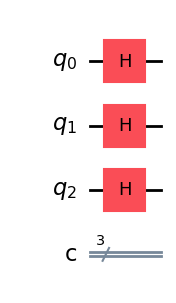

In [32]:
# Create a 3-qubit Grover circuit
grover_circuit = QuantumCircuit(3, 3)

# Apply Hadamard gates to the qubits to create a superposition
grover_circuit.h([0,1,2])

# Draw the circuit
grover_circuit.draw('mpl')

# The Quantum Oracle

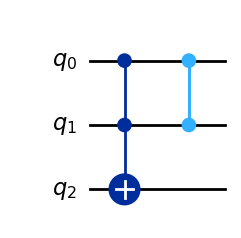

In [33]:
# Create a quantum circuit on 3 qubits
oracle = QuantumCircuit(3, name='oracle')

# Create a 3-qubit oracle
# The target state is |111>
oracle.ccx(0, 1, 2)

# Apply controlled-Z gate on first two qubits to mark |11>
oracle.cz(0, 1)

# Draw the circuit
oracle.draw('mpl')

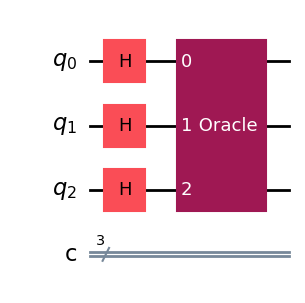

In [34]:
# Convert the oracle to a gate
oracle_gate = oracle.to_gate()
oracle_gate.label = " Oracle "

# Append the oracle gate to the grover circuit
grover_circuit.append(oracle_gate, [0, 1, 2])

grover_circuit.draw('mpl')

# Local simulation

In [35]:
# Simulate the circuit using the statevector simulator
backend = Aer.get_backend('statevector_simulator')
job = backend.run(transpile(grover_circuit, backend))
result = job.result()

# Get the statevector of the circuit
sv = result.get_statevector()

probabilities_before = np.round(sv, 2)

print("probabilities_before: \n", probabilities_before)

probabilities_before: 
 [ 0.35+0.j  0.35+0.j  0.35+0.j -0.35+0.j  0.35+0.j  0.35+0.j  0.35+0.j
 -0.35+0.j]


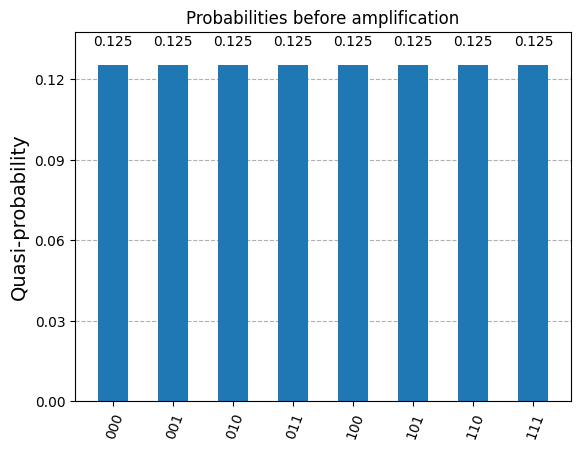

In [36]:
# Convert the statevector to probabilities
probabilities_before = np.abs(sv)**2

# Generate a dictionary of probabilities
labels = [f"{i:03b}" for i in range(2**3)]
probability_dict_before = dict(zip(labels, probabilities_before))

# Plot the histogram of probabilities before amplification
plot_histogram(probability_dict_before, title="Probabilities before amplification")

# Diffuser
- Amplification
- Perform reflection

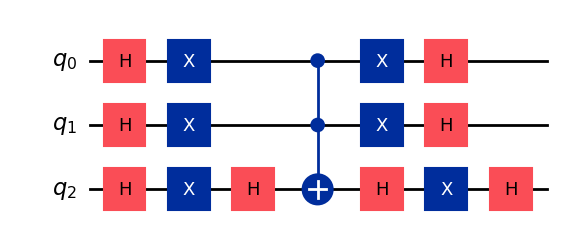

In [37]:
# Perform a reflection operation about the |000> state
reflection = QuantumCircuit(3, name='reflection')

# Apply Hadamard gates to all three qubits
reflection.h([0, 1, 2])

# Apply Pauli X gates to all three qubits
reflection.x([0, 1, 2])

# Apply a multi-controlled-Z gate (equivalent to a controlled-controlled-Z gate)
reflection.h(2)
reflection.ccx(0, 1, 2)
reflection.h(2)

# Apply Pauli X gates to all three qubits
reflection.x([0, 1, 2])

# Apply Hadamard gates to all three qubits to transform back to the computational basis
reflection.h([0, 1, 2])

# Convert the reflection circuit to a gate
reflection_gate = reflection.to_gate()
reflection_gate.label = "Diffuser"

reflection.draw('mpl')

# Complete Circuit

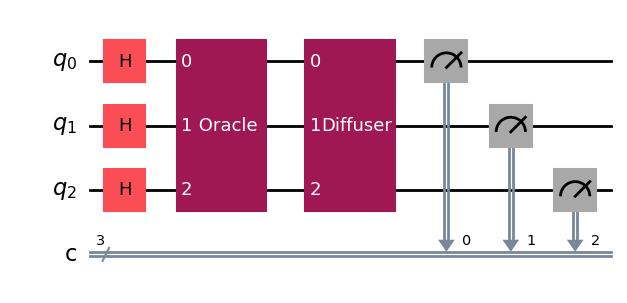

In [38]:
# Create a Grover circuit with the oracle and reflection
gc = QuantumCircuit(3, 3)

# Apply Hadamard gates to all three qubits
gc.h([0, 1, 2])

# Append the oracle
gc.append(oracle_gate, [0, 1, 2])

# Append the reflection
gc.append(reflection_gate, [0, 1, 2])

# Measure the qubits
gc.measure([0, 1, 2], [0, 1, 2])

gc.draw('mpl')

# Simulation with QASM

In [39]:
# Simulate the circuit using the qasm simulator
backend = Aer.get_backend('qasm_simulator')

# Run the job with only a single shot
circuit = transpile(gc, backend)
job = backend.run(circuit, shots=1000)

result = job.result()

In [40]:
# Get the counts of the circuit
counts_after = result.get_counts()
print("Counts after amplification:", counts_after)

Counts after amplification: {'111': 503, '011': 497}


# Simulation with IBM Quantum Computer

In [391]:
# To run on hardware
service = QiskitRuntimeService(channel="ibm_quantum")

# Select the backend with the fewest number of jobs in the queue
backend = service.least_busy(operational=True, simulator=False)

# Display the backend name
backend.name

'ibm_osaka'

Optimize problem for quantum execution

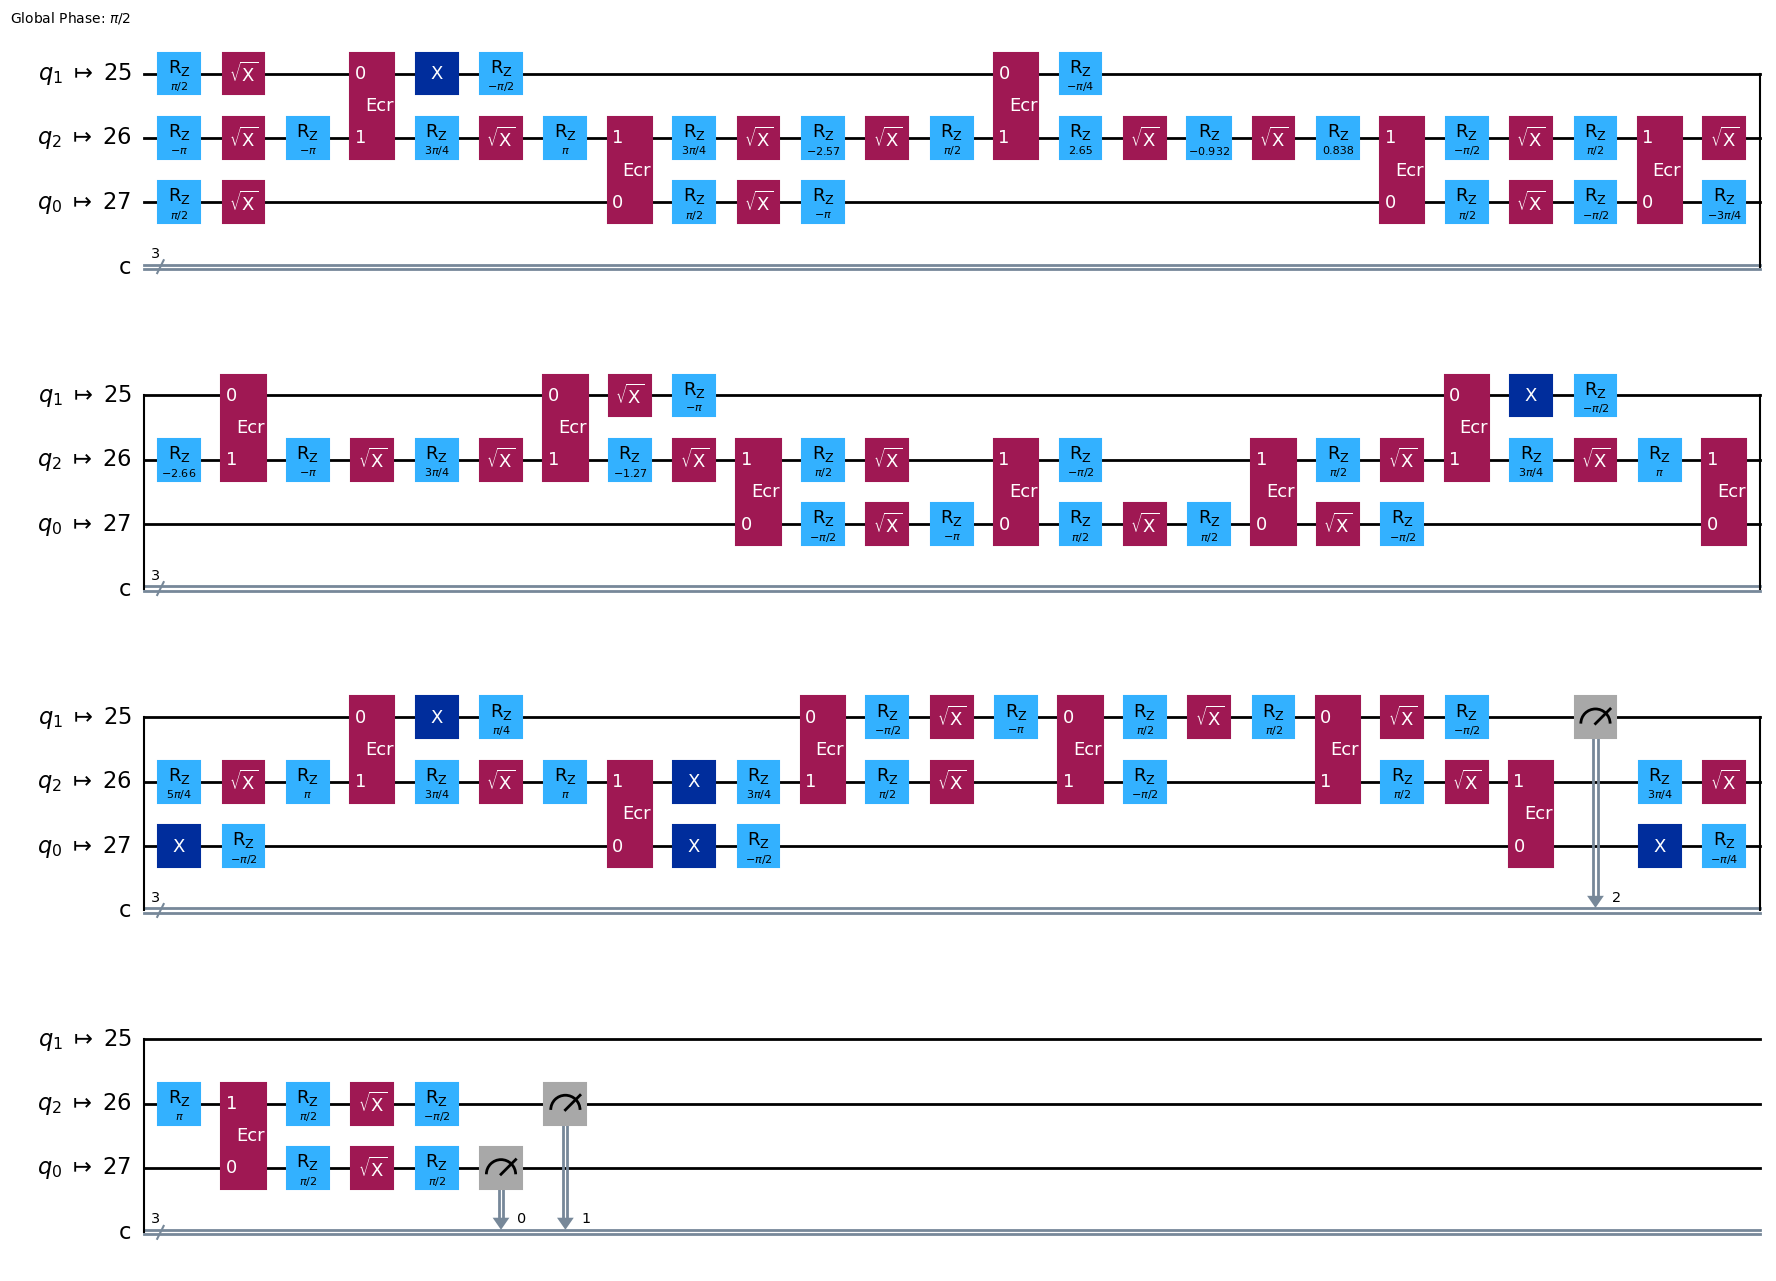

In [392]:
target = backend.target

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(gc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [393]:
# Optimize the circuit for the target backend
transpiled_gc = transpile(gc, backend, optimization_level=3)

# Execute the transpiled circuit on the backend
job = backend.run(transpiled_gc, shots=1000)

/var/folders/kd/9h3yrkps2vj0t9zs17vt349c0000gn/T/ipykernel_78267/755522137.py:5: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_gc, shots=1000)


In [394]:
# Retrieve the result
result = job.result()
counts = result.get_counts()

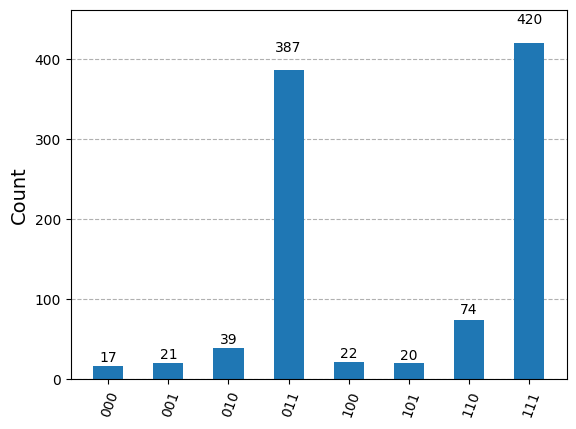

In [395]:
# Plot the histogram of results
plot_histogram(counts)